In [17]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models import ShuffleNetV2
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [18]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [19]:
artifact_path = Path("../../artifacts/shufflenetv2")
data_path = Path("../../data/gtsrb")

In [20]:
device = torch.device("cuda:0")

# data

In [21]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [22]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [23]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [24]:
num_class = 43

In [25]:
len(train_dataset)

26640

38


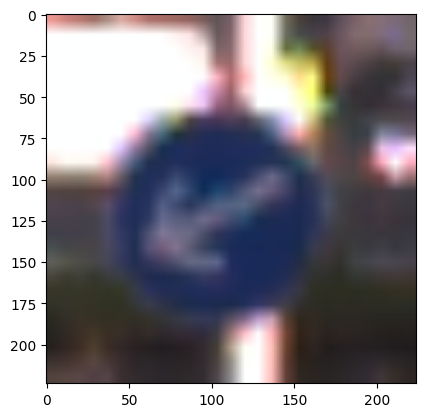

In [26]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [27]:
model = ShuffleNetV2(output_size=num_class, groups=4).to(device)

In [28]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
ShuffleNetV2                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 648
│    │    └─BatchNorm2d: 3-2                            48
│    │    └─ReLU: 3-3                                   --
│    └─MaxPool2d: 2-2                                   --
├─Sequential: 1-2                                       --
│    └─ResBlock: 2-3                                    --
│    │    └─BottleNeck: 3-4                             5,626
│    │    └─Sequential: 3-5                             1,772
│    │    └─ChannelShuffle: 3-6                         --
│    └─ResBlock: 2-4                                    --
│    │    └─BottleNeck: 3-7                             7,598
│    │    └─Identity: 3-8                               --
│    │    └─ChannelShuffle: 3-9          

# training

In [29]:
epoches = 10
acc_iters = 256 // BATCH_SIZE

In [30]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [31]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [32]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 416/416 [03:40<00:00,  1.89it/s]


epoch 1 : 0.009833900677711846


100%|██████████| 416/416 [01:09<00:00,  5.97it/s]


epoch 2 : 0.003969884361979963


100%|██████████| 416/416 [01:12<00:00,  5.70it/s]


epoch 3 : 0.0012955123921318983


100%|██████████| 416/416 [01:09<00:00,  5.99it/s]


epoch 4 : 0.0005398475718720874


100%|██████████| 416/416 [01:09<00:00,  5.98it/s]


epoch 5 : 0.00029380033454519714


100%|██████████| 416/416 [01:11<00:00,  5.85it/s]


epoch 6 : 0.00020749416713582692


100%|██████████| 416/416 [01:10<00:00,  5.92it/s]


epoch 7 : 0.0002000510656942494


100%|██████████| 416/416 [01:14<00:00,  5.56it/s]


epoch 8 : 0.00011173239270170562


100%|██████████| 416/416 [01:16<00:00,  5.41it/s]


epoch 9 : 0.00010721528632127677


100%|██████████| 416/416 [01:13<00:00,  5.70it/s]

epoch 10 : 7.942277998897505e-05


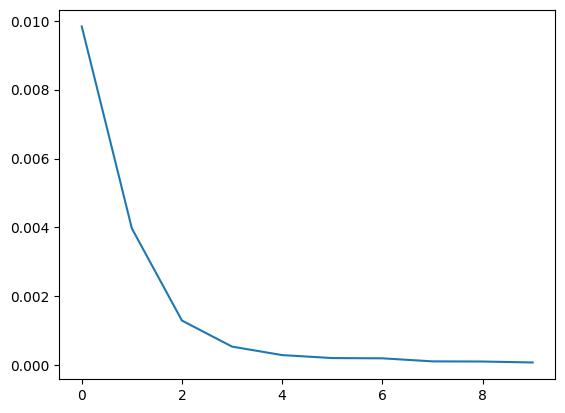

In [33]:
plt.plot(training_loss)

# inference

In [34]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [35]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [36]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [37]:
evaluator = ClassificationEvaluator(num_class, device)

In [38]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [02:27<00:00,  1.34it/s]

[[ 18  40   0 ...   0   0   0]
 [  0 670  28 ...   0   0   0]
 [  0   7 718 ...   0   0   0]
 ...
 [  0   0   0 ...  78   0   0]
 [  0   0   0 ...   0  41  10]
 [  0   0   0 ...   0  14  60]]


In [39]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.3
1         : 0.9305555555555556
2         : 0.9573333333333334
3         : 0.8911111111111111
4         : 0.9575757575757575
5         : 0.8793650793650793
6         : 0.8266666666666667
7         : 0.78
8         : 0.8688888888888889
9         : 0.9958333333333333
10        : 0.9954545454545455
11        : 0.9404761904761905
12        : 0.8681159420289855
13        : 0.9958333333333333
14        : 0.9629629629629629
15        : 0.9571428571428572
16        : 0.9733333333333334
17        : 0.9194444444444444
18        : 0.6871794871794872
19        : 0.8
20        : 0.5555555555555556
21        : 0.6
22        : 0.9166666666666666
23        : 0.7533333333333333
24        : 0.9444444444444444
25        : 0.9020833333333333
26        : 0.9166666666666666
27        : 0.48333333333333334
28        : 0.88
29        : 0.8888888888888888
30        : 0.30666666666666664
31        : 0.9444444444444444
32        : 0.95
33        : 0.7142857142857143
34        : 0.9333333333333333


In [40]:
per_class_acc.mean()

0.8156256451016308

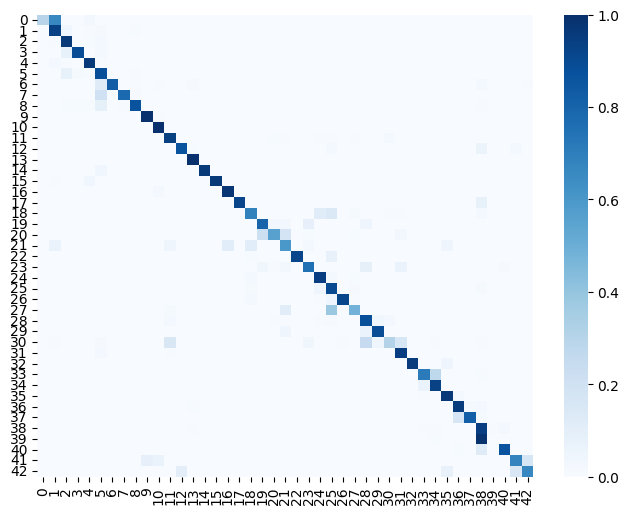

In [41]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [42]:
model_path = artifact_path / f'shufflenetv2.pth'

In [43]:
torch.save(model.state_dict(), model_path)

In [44]:
get_file_size(model_path)

'5.12MB'

In [45]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>